<a class="anchor" id="top"></a>
# Table of Content:
## [1.Introduction](#1)
[1.1 Import libraries](#1.1)

[1.2 Define file paths](#1.2)

[1.3 DataSets Overview](#1.3)
## [2. Preprocess the data](#2)
[2.1 Alcohol consumption](#2.1)

[2.2 Policies](#2.2)

* [2.2.1 Tax, Liscence, Community_action, Health_warning](#2.2.1)
* [2.2.2 Restricitons on alcohol use in public places](#2.2.2)
* [2.2.3 Age limit for alcohol service and sale](#2.2.3)
* [2.2.4 Agglomerate all policies together](#2.2.4)
* [2.2.5 Handling missing values](#2.2.5)

[2.3 Human Development Reports (HDR) factors](#2.3)

[2.4 Regions and religions](#2.4)

[2.5 Datasets standardization and agglomeration](#2.5)

## [3 Datasets visualization](#3)
[3.1 World map by alcohol consumption in 2009-2011 and 2015-2017](#3.1)

[3.2 World map by religions](#3.2)

[3.3 Visualize alcohol policies](#3.3)

* [3.3.1 Frequencies of alcohol policies in the world](#3.3.1)
* [3.3.2 Alcohol policies by region and by religion](#3.3.2)

## [4 Identification...]

# 1. Introduction <a class="anchor" id="1"></a>

Harmful use of alcohol causes more than 5% of the global disease burden. The death of more than [3 million people](https://www.who.int/news-room/detail/21-09-2018-harmful-use-of-alcohol-kills-more-than-3-million-people-each-year--most-of-them-men) a year is caused by the substance. Simultaneously it is source of a [1344 billion dollar industry](https://www.statista.com/statistics/696641/market-value-alcoholic-beverages-worldwide/), and an important cultural factor. This makes it a highly important, and highly complex, matter for regulators which have to take into account many aspects when creating policies.

The goal of this notebook is to aggregate different alcohol control policies to understand which are the most common and test the correlation between alcohol consumption and different alcohol control policies


## 1.1 Import libraries <a class="anchor" id="1.1"></a>

In order to keep this notebook as clean as possible, we created the python package `preprocess_data` which contains all the home-made functions used in this notebook, mainly to preprocess the data

In [73]:
# import libraries
from preprocess_data import *
import os
import pandas as pd
import numpy as np
import csv

import warnings
import re

import geopandas
import folium
from folium import plugins

from IPython.core.display import display, HTML
from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

import matplotlib.pylab as pylab
import matplotlib.pyplot as plt

import plotly.io as pio
import plotly.graph_objects as go
import chart_studio
import chart_studio.plotly as py
import chart_studio.tools as tls

# import geoplot
pylab.rcParams['figure.figsize'] = 20, 20

In [74]:
username = 'EPFLTURNER'
api_key = 'qUybgqyd9eNFcvczkQTk'
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

## 1.2 Define file paths <a class="anchor" id="1.2"></a>

In [75]:
#original_file_PATH_definitions
projectdata_PATH = "../data/projectdata/"
dataprocessed_PATH = "../data/dataprocessed/"

In [76]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

## 1.3 DataSets Overview <a class="anchor" id="1.3"></a>

**DataSet 1. Pure alcohol consumption, litres per capita, age 15+**


* Data type: Numerical

* Unit: Litres per capita

* Rationale: This is the indicator we want to analyze

* Method of estimation: The national authorities of a given country respond to the Global Survey on Alcohol and Health.

* Year of measurement: 2010 and 2016


Short name: Alcohol consumption


Total countries:194

In [77]:
display(HTML('<iframe id=\'rightframe\' name=\'leftiframe\' width="100%" src=\'http://apps.who.int/gho/data/node.gisah.A1029\'></iframe><br>'))

**DataSet 2. Alcohol control policies: Global information system on alcohol and health**
* Short name: Policies

* Data type: Categorical

* Rationale: Legislators create alcohol control policies with the goal of affecting several behaviours related to alcohol consumption and generally to decrease the consumption

* Method of estimation: The national authorities of a given country respond to the Global Survey on Alcohol and Health.

* Year of measure: 2016

* List of choosen datasets in this section:
    - Age limits to serve (on-premise service) and sell (off-premise sales) alcohol
    - Community action (earmarked funds for community action, provision of technical tools tailored to communities, training programmes, community programmes and policies for subgroups at particular risk)
    - Licensing requirements for retail sales and alcohol production
    - Restrictions on alcohol use in public places pertain to: education buildings, government offices, healthcare establishments, leisure events, parks and streets, public transport, religious places, sporting events, workplace. 

# link this to the hierarchy df

In [78]:
display(HTML('<iframe id=\'rightframe\' name=\'leftiframe\' width="100%" src=\'http://apps.who.int/gho/data/node.gisah.A1119\'></iframe><br>'))

**DataSet 3. Human Development Reports: GDP, Education Index, Unemployment, Median age, Human Development Index**

* Short name: HDR factors

* Data type: Numerical

* Rationale: Several socio-economical factors can influence the alcohol consumption of a population. For this reason we have chosen several indicators used by the UN development agency, to see what influence they have and how their influence compares to alcohol control policies.

* Method of estimation: Answer from statistical department of the respective governments.

* Year of measure: Yearly from 2000, every five years before

In [79]:
display(HTML('<iframe id=\'rightframe\' name=\'leftiframe\' width="100%" src=\'http://hdr.undp.org/en/data\'></iframe><br>'))

**DataSet 4. United Nations Regional Groups**

* Short name: Regions

* Data type: Categorical

* Rationale: Alcohol consumption of a country is probably highly dependent from which region of the world the country is situated

In [80]:
display(HTML('<iframe id=\'rightframe\' name=\'leftiframe\' height="100%" width="100%" src=\'https://en.wikipedia.org/wiki/United_Nations_Regional_Groups\'></iframe><br>'))



**DataSet 5. Major Religions in Countries**

* Short name: Religions

* Data type: Categorical

* Rationale: Religion and its approach is a major factor to take into account when comparing countries as many religions dictate a certain approach to consumption

In [81]:
display(HTML('<iframe id=\'rightframe\' name=\'leftiframe\' width="100%" src=\'https://www.nationmaster.com/country-info/stats/Religion/Religions/All\'></iframe><br>'))

# 2. Preprocess the data <a class="anchor" id="2"></a>
## 2.1 Alcohol consumption  <a class="anchor" id="2.1"></a>

In [82]:
process_country_name(projectdata_PATH+"Consumption.csv", dataprocessed_PATH+"Consumption_namecleaned.csv", 0)

In [83]:
df_consumption = pd.read_csv(dataprocessed_PATH + "Consumption_namecleaned.csv", header=0, sep=',', names=['Country', '2015-2017', '2009-2011'])
df_consumption.head()

,Country,2015-2017,2009-2011
0,Afghanistan,0 [0-0],0 [0-0]
1,Albania,5 [4.9-5.1],5.7 [5.6-5.9]
2,Algeria,0.6 [0.6-0.6],0.4 [0.4-0.4]
3,Andorra,10.1 [9.9-10.3],11 [10.8-11.2]
4,Angola,5 [4.9-5.1],7.5 [7.3-7.6]


### Split the consumption value and 95%CI 

In [84]:
df_consumption = pd.read_csv(dataprocessed_PATH + "Consumption_namecleaned.csv", header=0, sep=',', names=['Country', '2015-2017', '2009-2011'])
df_consumption['Alcohol_per_capita_2015-2017'], df_consumption['Alcohol_per_capita_2015-2017_95%CI'] = df_consumption['2015-2017'].str.split('[', 1).str
df_consumption['Alcohol_per_capita_2009-2011'], df_consumption['Alcohol_per_capita_2009-2011_95%CI'] = df_consumption['2009-2011'].str.split('[', 1).str
df_consumption = df_consumption[['Country', 'Alcohol_per_capita_2015-2017', 'Alcohol_per_capita_2015-2017_95%CI', 
                                 'Alcohol_per_capita_2009-2011', 'Alcohol_per_capita_2009-2011_95%CI']]
for row in df_consumption.iterrows():
    if isinstance(row[1][2], str):
        row[1][2] = row[1][2].replace("]", "")
    if isinstance(row[1][4], str):
        row[1][4] = row[1][4].replace("]", "")
df_consumption = df_consumption[1:]
df_consumption['Alcohol_per_capita_2009-2011'].astype(dtype=float)
df_consumption['Alcohol_per_capita_2015-2017'].astype(dtype=float)
df_consumption.to_csv(dataprocessed_PATH + "Consumption_final.csv", index=False, sep=',')

In [85]:
df_consumption = pd.read_csv(dataprocessed_PATH + "Consumption_final.csv").set_index('Country')
df_consumption.head()

,Alcohol_per_capita_2015-2017,Alcohol_per_capita_2015-2017_95%CI,Alcohol_per_capita_2009-2011,Alcohol_per_capita_2009-2011_95%CI
Country,,,,
Albania,5.0,4.9-5.1,5.7,5.6-5.9
Algeria,0.6,0.6-0.6,0.4,0.4-0.4
Andorra,10.1,9.9-10.3,11.0,10.8-11.2
Angola,5.0,4.9-5.1,7.5,7.3-7.6
Antiguaandbarbuda,8.5,8.3-8.6,7.9,7.7-8


## 2.2 Policies <a class="anchor" id="2.2"></a>
### 2.2.1 Tax, Liscence, Community_action, Health_warning <a class="anchor" id="2.2.1"></a>

We start to sanitize the four simplest datasets.

* Data transformation: from categorical to numerial
    * Type of transformations: Turning Yes/No to 1/0
* Missing data handling policy: the function `preprocess_data_file` calls the function `leave_out_nodata` which removes the countries for which we have absolutely no data (i.e. Afghanistan is often from those countries)

In [86]:
preprocess_data_file(projectdata_PATH + "Tax.csv", dataprocessed_PATH + "Tax.csv")
preprocess_data_file(projectdata_PATH + "Licence_production.csv", dataprocessed_PATH + "Licence_production.csv")
preprocess_data_file(projectdata_PATH + "Licence_retail.csv", dataprocessed_PATH + "Licence_retail.csv")
preprocess_data_file(projectdata_PATH + "Community_actions.csv", dataprocessed_PATH + "Community_actions.csv")
preprocess_data_file_one(projectdata_PATH + "Health_warning.csv", dataprocessed_PATH + "Heatlh_warning.csv")

In [87]:
# print every file after cleaning
df_tax = pd.read_csv(dataprocessed_PATH + "Tax.csv", sep=',')

In [88]:
df_liscence_production = pd.read_csv(dataprocessed_PATH + "Licence_production.csv", sep=',')

In [89]:
df_liscence_retail = pd.read_csv(dataprocessed_PATH + "Licence_retail.csv", sep=',')

In [90]:
df_community_actions = pd.read_csv(dataprocessed_PATH + "Community_actions.csv", sep=',')

In [91]:
df_health_warning = pd.read_csv(dataprocessed_PATH + "Heatlh_warning.csv", sep=',')

### 2.2.2 Restricitons on alcohol use in public places  <a class="anchor" id="2.2.2"></a>

 change text to value
 
Replacing text value according to below:

ban                                               1

partial restriction                             0.5

voluntary/self-restricted                       0.3 (this parameter can be changed)

no restrictions                                  0

leave out nodata rows:

No data        

In [92]:
b = pd.read_csv(projectdata_PATH + "Public_use.csv", header=None, sep=',')
b = pd.DataFrame(b)
for i in range(2, 4):
    print("Value_counts for column", i, "\n")
    print(b[i].value_counts())

Value_counts for column 2 

ban                               108
voluntary/self-restricted          28
No data                            27
partial restriction                19
no restrictions                    12
Restrictions on alcohol use in      1
 Educational buildings              1
Name: 2, dtype: int64
Value_counts for column 3 

ban                               91
voluntary/self-restricted         30
No data                           27
no restrictions                   24
partial restriction               22
Restrictions on alcohol use in     1
 Government offices                1
Name: 3, dtype: int64


In [93]:
preprocess_public_use_data(projectdata_PATH + "Public_use.csv", dataprocessed_PATH + "Public_use.csv")
df_public_use = pd.read_csv(dataprocessed_PATH + "Public_use.csv", sep=',')

### 2.2.3 Age limit for alcohol service and sale <a class="anchor" id="2.2.3"></a>

change text to value

Using max min scale, (0, age value, Total ban=50) ~ (0,1)

None              0

15  16  17  18  19  20  21  25

Total ban          50

Subnational 2      drop

No data  21       drop


In [94]:
preprocess_age_limits(projectdata_PATH + "Age_limits.csv", dataprocessed_PATH + 'Age_limits.csv')
df_age_limits = pd.read_csv(dataprocessed_PATH + 'Age_limits.csv', sep=',')

### 2.2.4 Agglomerate all policies together <a class="anchor" id="2.2.4"></a>

In [95]:
# creates one DataFrame with all the policies
df_policy = df_age_limits.set_index(['Country','Year']).join([df_community_actions.set_index(['Country','Year']), 
                                                  df_health_warning.set_index(['Country','Year']),
                                                  df_liscence_production.set_index(['Country','Year']),
                                                  df_liscence_retail.set_index(['Country','Year']),
                                                  df_tax.set_index(['Country','Year']),
                                                  df_public_use.set_index(['Country','Year'])],
                                                  how='outer')
df_policy = df_policy.reset_index('Year')
df_policy = df_policy.drop(labels='Year', axis='columns')

### 2.2.5 Handling missing values <a class="anchor" id="2.2.5"></a>

In [96]:
# drops countries where there is no data in all columns
before=df_policy.shape[0]
df_policy=df_policy.dropna(axis='rows', how='all')
after=df_policy.shape[0]
print('Initial #countries:', before, '; #countries removed:', before-after)

Initial #countries: 194 ; #countries removed: 17


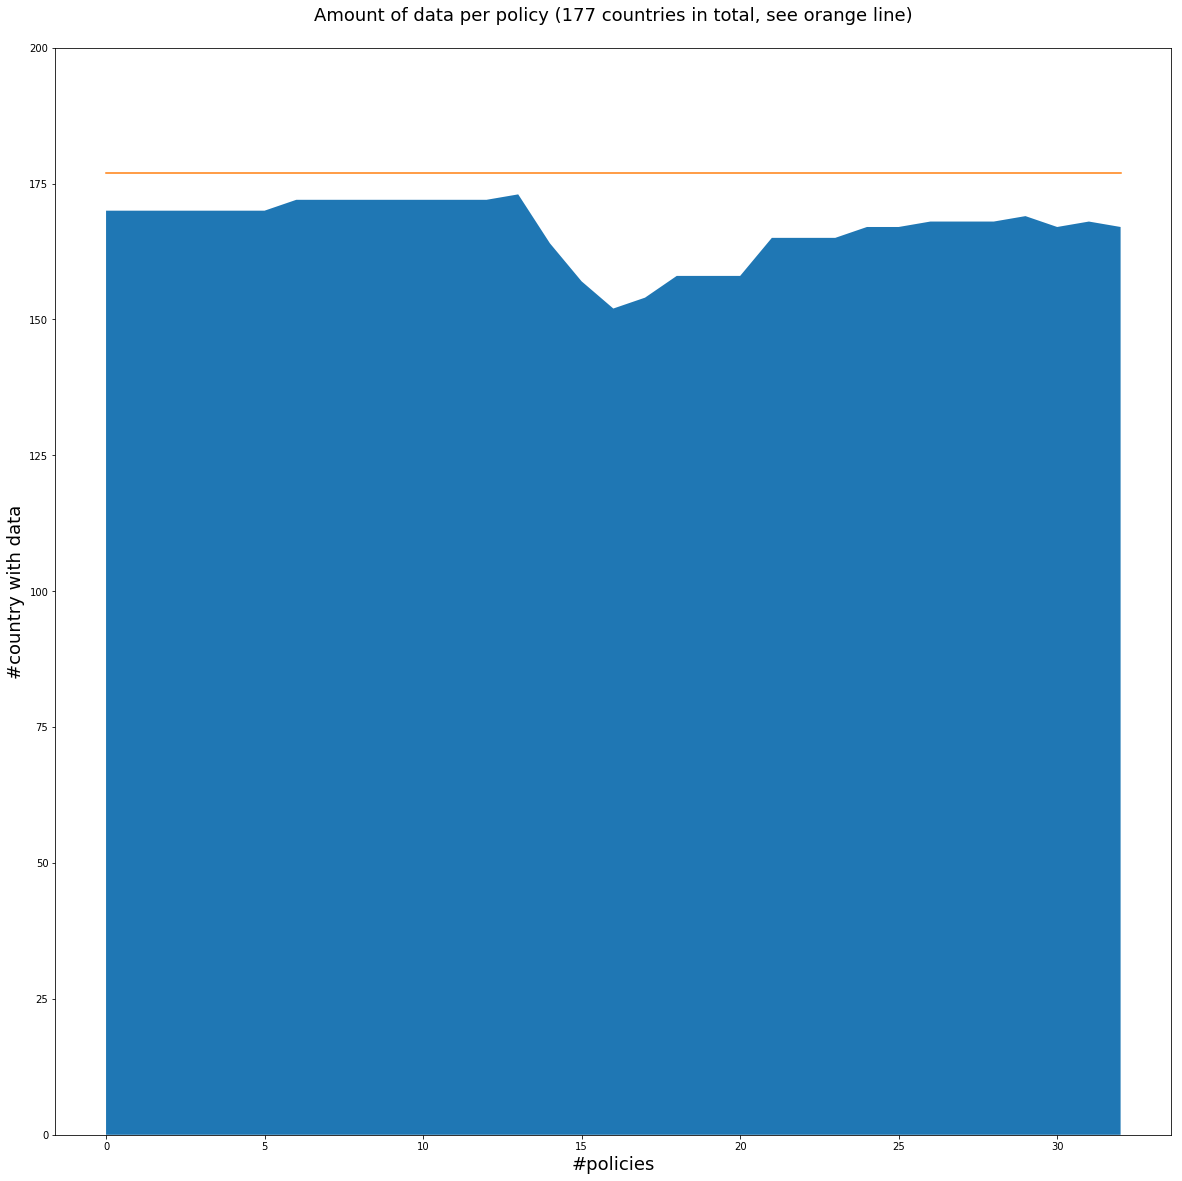

In [97]:
# visualize how many countries are missing per policy
n_countries=df_policy.shape[0]
plt.stackplot(range(len(df_policy.columns)),df_policy.count())
plt.plot(np.linspace(n_countries,n_countries,len(df_policy.columns)), )
plt.xlabel("#policies", fontsize=18)
plt.ylabel("#country with data", fontsize=18)
plt.ylim(0, 200)
plt.title('Amount of data per policy (' + str(n_countries) +' countries in total, see orange line)\n', fontsize=18)
plt.show()

#### Imputation
Looking at the graph, as there is a low number of missing data, we choose to impute the missing values with mean so as to keep as much meaningful data as possible

In [98]:
df_policy.fillna(df_policy.mean(), inplace=True)
print('Final shape:', df_policy.shape)

Final shape: (177, 33)


## 2.3 Human Development Reports (HDR) factors  <a class="anchor" id="2.3"></a>

In [99]:
#creates dataframes for each HDR factor
df_hdi = pd.read_csv(projectdata_PATH + "Human_Development_Index.csv").replace('..',np.nan)
df_unempl = pd.read_csv(projectdata_PATH + "Unemployment.csv").replace('..',np.nan)
df_median = pd.read_csv(projectdata_PATH + "Median_age.csv").replace('..',np.nan)
df_gdp = pd.read_csv(projectdata_PATH + "GDP.csv").replace('..',np.nan)
df_edu = pd.read_csv(projectdata_PATH + "Education_Index.csv").replace('..',np.nan)

In [100]:
# agglomerates all HDR factor in one DataFrame
df_hdr = df_hdi.set_index(['Country','Year']).join([df_unempl.set_index(['Country','Year']), 
                                                  df_median.set_index(['Country','Year']),
                                                  df_gdp.set_index(['Country','Year']),
                                                  df_edu.set_index(['Country','Year'])],
                                                  how='outer')
df_hdr = df_hdr.reset_index('Year')
df_hdr = df_hdr.drop(labels='Year', axis='columns')
df_hdr = df_hdr.rename({'iso3':'Code'}, axis=1)
df_hdr = df_hdr[:-1].astype(dtype=float)
print('Final shape:', df_hdr.shape)
df_hdr.head()

Final shape: (195, 5)


,HDI_2016,"Unemployment, total (% of labour force)",Median age (years),Gross domestic product (GDP) per capita (2011 PPP $),Education Index
Country,,,,,
Afghanistan,0.494,8.8,17.3,1803.0,0.410
Albania,0.782,15.2,36.2,11356.0,0.742
Algeria,0.753,10.2,27.5,13921.0,0.663
Andorra,0.856,NaN,NaN,NaN,0.714
Angola,0.577,7.7,16.4,5972.0,0.487


In [101]:
#standardizing names as used for policies
as_list = df_hdr.index.tolist()
idx = as_list.index('Korea (Democratic People\'s Rep. of)')
as_list[idx] = 'Democratic People\'s Republic of Korea'
idx = as_list.index('Korea (Republic of)')
as_list[idx] = 'Republic of Korea'
idx = as_list.index('Moldova (Republic of)')
as_list[idx] = 'Republic of Moldova'
idx = as_list.index('The former Yugoslav Republic of Macedonia')
as_list[idx] = 'Republic of North Macedonia'
idx = as_list.index('United Kingdom')
as_list[idx] = 'United Kingdom of Great Britain and Northern Ireland'
idx = as_list.index('United States')
as_list[idx] = 'United States of America'
idx = as_list.index('Congo (Democratic Republic of the)')
as_list[idx] = 'Democratic Republic of the Congo'
idx = as_list.index('Eswatini (Kingdom of)')
as_list[idx] = 'Eswatini'
df_hdr.index = as_list

## 2.4 Regions and religions <a class="anchor" id="2.4"></a>

We have divided all the countries in the database into eight parts according to the United Nations geographical division criteria.

Reason: we think that countries from the same region have similar political conditions, living habits and cultural background; for example countries in the EU. However countries from different regions could be quite different in these aspects. Hence, we would like to see how does alcohol consumption clusters on regions.

In [102]:
df_rel_reg = pd.read_csv(projectdata_PATH + "Country_list.csv")

# sanitizes the religion data and save to csv
df_rel_reg.Religion = df_rel_reg.Religion.apply(lambda x: x.strip(' .'))
df_rel_reg.Religion = df_rel_reg.Religion.replace({'indigenous beliefs':'Indigenous beliefs',
                                                      'Islam: Sunni':'Islam Sunni'})
df_rel_reg.to_csv(dataprocessed_PATH + "Country_list.csv")

print('List of regions: ', df_rel_reg.Region.unique(), '\n\nList of religions: ', df_rel_reg.Religion.unique())

List of regions:  ['African Group' 'Asia-Pacific Group' 'Western European and Others Group'
 'Eastern European Group' 'Latin American and Caribbean Group'] 

List of religions:  ['Islam' 'Indigenous beliefs' 'Christian' 'Roman Catholic' 'Islam Sunni'
 'Protestant' 'traditional' 'Hindu' 'Mozambique' 'Buddhist'
 'Officially atheist' 'Orthodox' 'Shintoist and Buddhist'
 'Congregationalist' 'Church of Melanesia' 'Church of Tuvalu'
 'Armenian Apostolic' 'Catholic' 'Baptist' 'Judaism' 'Anglican']


We have some countries that are not in our region and religion dataset. This is probably due to the fact that the regional division is from a UN dataset and some smaller countries are not part of the UN

## 2.5 Datasets standardization and agglomeration <a class="anchor" id="2.5"></a>

We will join the datasets by Countries bcecause it is the feature that they all have in common. However this is tricky since there are different ways to write some countries names. Example `Burkina Faso` and `BurkinaFaso` or `Congo Kinshasa` and `Congo (Kinshasa)`. 

To overcome this challenge, we decided to join the datasets based on the ISO 3166-1 alpha-3 codes standard (it is a three-letter country codes defined in ISO 3166-1, part of the ISO 3166 standard published by the International Organization for Standardization, to represent countries, dependent territories, and special areas of geographical interest.).
The function `process_countries` aims to add this `iso3` standard to the COuntry list for future joins on Data Frames.

In [103]:
# Process the countries and add thei latitue and longitude (this will be used for the visualization)
process_countries(dataprocessed_PATH + "Country_list.csv", dataprocessed_PATH + "Country_list_lat_long_final.csv")
df_country_location = pd.read_csv(dataprocessed_PATH + 'Country_list_lat_long_final.csv', sep=',')
df_country_location=df_country_location.set_index('Country').drop(labels='Number',axis=1)
df_country_location.head()

Successfully Converted: 173


,iso2,iso3,latitude,longitude,Region,Religion
Country,,,,,,
Algeria,DZ,DZA,28.033886,1.659626,African Group,Islam
Angola,AO,AGO,-11.202692,17.873887,African Group,Indigenous beliefs
Benin,BJ,BEN,9.30769,2.315834,African Group,Indigenous beliefs
Botswana,BW,BWA,-22.328474,24.684866,African Group,Christian
Burkinafaso,BF,BFA,12.238333,-1.561593,African Group,Islam


### Impactful features
The Data Frame df_all concentrates all the features that where seleted to study their impact on alcohol consumption. It also adds the ISO 3166-1 alpha-3 codes standard that was derived just above.

In [104]:
df_all = df_policy.join([df_hdr, df_country_location.drop(labels={'latitude','longitude','iso2'},axis=1)], how= 'left')
df_all = df_all.dropna(axis=0, subset=['HDI_2016'])
df_all = df_all.rename({'iso3':'Code'}, axis=1)
pd.set_option('display.max_rows', df_all.shape[0]+1)
print('List of the observed features: ', df_all.columns)

List of the observed features:  Index(['Age limits off-premise sales for beer',
       'Age limits off-premise sales for wine',
       'Age limits off-premise sales for spirits',
       'Age limits on-premise service for beer',
       'Age limits on-premise service for wine',
       'Age limits on-premise service for spirits',
       'Government support for earmarked funds',
       'Government support for technical tools',
       'Government support for training programmes',
       'Government support for at-risk groups targeted',
       'Government support for community programmes',
       'Government support for provision of information',
       'Government support for data dissemination',
       'Government support for research studies',
       'Health warning labels on alcohol containers',
       'Licence for beer production', 'Licence for wine production',
       'Licence for spirits production', 'Licence for beer retail sales',
       'Licence for wine retail sales', 'Licence for

### Alcohol consumption features
In this dataframe we add the ISO 3166-1 alpha-3 codes standard onto the alcohol consumption. It also adds Religion and Regions clusters for future visualisation.

In [105]:
# DataFrame with the alcohol consumption
finaldf = pd.merge(df_country_location, df_consumption, on='Country')
finaldf.to_csv(dataprocessed_PATH + "Countries_finaldf.csv", index=False, sep=',', 
               header=['iso2', 'iso_a3', 'latitude', 'longitude', 'Region', 'Religion', 
                       'Alcohol_per_capita_2015-2017', 'Alcohol_per_capita_2015-2017_95%CI', 
                       'Alcohol_per_capita_2009-2011', 'Alcohol_per_capita_2009-2011_95%CI'])
finaldf.head()

,iso2,iso3,latitude,longitude,Region,Religion,Alcohol_per_capita_2015-2017,Alcohol_per_capita_2015-2017_95%CI,Alcohol_per_capita_2009-2011,Alcohol_per_capita_2009-2011_95%CI
Country,,,,,,,,,,
Algeria,DZ,DZA,28.033886,1.659626,African Group,Islam,0.6,0.6-0.6,0.4,0.4-0.4
Angola,AO,AGO,-11.202692,17.873887,African Group,Indigenous beliefs,5.0,4.9-5.1,7.5,7.3-7.6
Benin,BJ,BEN,9.30769,2.315834,African Group,Indigenous beliefs,1.6,1.5-1.6,1.3,1.3-1.4
Botswana,BW,BWA,-22.328474,24.684866,African Group,Christian,6.2,6.1-6.3,5.6,5.5-5.8
Burkinafaso,BF,BFA,12.238333,-1.561593,African Group,Islam,4.9,4.8-5,4.6,4.5-4.7


# 3 Datasets visualization  <a class="anchor" id="3"></a>

In this section we want to analyse what kind of policies are present in different parts of the world and understand why

## 3.1 World map by alcohol consumption in 2009-2011 and 2015-2017 <a class="anchor" id="3.1"></a>

In [212]:
# Merging world shape data with our alcohol consumption data
%matplotlib inline
pylab.rcParams['figure.figsize'] = 18, 18
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
finaldf = finaldf.rename(columns={'iso3':'iso_a3'})
world = world.merge(finaldf, on='iso_a3')

In [213]:
# rename the columns of the dataframe world and sort them
world = world.rename(columns={'Alcohol_per_capita_2015-2017':'Alcohol_com1'})
world = world.rename(columns={'Alcohol_per_capita_2009-2011':'Alcohol_com2'})
world['Alcohol_com1'] = world.Alcohol_com1
world['Alcohol_com2'] = world.Alcohol_com2
world['iso_a3'] = world.iso_a3
world['Region'] = world.Region
world['Religion'] = world.Religion
world['name'] = world.name
world['iso2'] = world.iso2
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,iso2,latitude,longitude,Region,Religion,Alcohol_com1,Alcohol_per_capita_2015-2017_95%CI,Alcohol_com2,Alcohol_per_capita_2009-2011_95%CI
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",FJ,-16.578193,179.414413,Asia-Pacific Group,Christian,2.2,2.2-2.3,2.2,2.2-2.3
1,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",CA,56.130366,-106.346771,Western European and Others Group,Roman Catholic,8.1,8-8.3,8.3,8.2-8.5
2,18556698,Asia,Kazakhstan,KAZ,460700.0,"POLYGON ((87.35997 49.21498, 86.59878 48.54918...",KZ,48.019573,66.923684,Asia-Pacific Group,Islam,5.8,5.7-5.9,6.5,6.3-6.6
3,29748859,Asia,Uzbekistan,UZB,202300.0,"POLYGON ((55.96819 41.30864, 55.92892 44.99586...",UZ,41.377491,64.585262,Asia-Pacific Group,Islam,1.6,1.6-1.6,1.8,1.8-1.8
4,6909701,Oceania,Papua New Guinea,PNG,28020.0,"MULTIPOLYGON (((141.00021 -2.60015, 142.73525 ...",PG,-6.314993,143.95555,Asia-Pacific Group,Roman Catholic,0.7,0.7-0.7,0.8,0.8-0.8


In [214]:
# Draw Alcohol consumptions by each country for the first time period 2015-2017
for col in world.columns:
    world[col] = world[col].astype(str)

world['text'] = world['name'] + '<br>' + \
    'Region ' + world['Region'] + '<br>' + 'Religion ' + world['Religion'] + '<br>' + \
    'Alcohol Consumption 2015-2017 ' + world['Alcohol_com1'] + ' Alcohol Consumption 2009-2011 ' + world['Alcohol_com2']

fig = go.Figure(data=go.Choropleth(
    locations=world['iso_a3'].astype(str),
    z=world['Alcohol_com1'].astype(float),
    colorscale='Reds',
    autocolorscale=False,
    reversescale=True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_tickprefix = 'liter per capita ',
    colorbar_title = 'Alcohol Consumption<br>Liter Per Capita',
    text=world['text'], # hover text
))

fig.update_layout(
    title_text='Average Alcohol consumption 2015-2017 by Country',
    geo = dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
    
)

fig.show()

In [215]:
fig = go.Figure(data=go.Choropleth(
    locations=world['iso_a3'].astype(str),
    z=world['Alcohol_com2'].astype(float),
    colorscale='Reds',
    autocolorscale=False,
    reversescale=True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_tickprefix = 'liter per capita ',
    colorbar_title = 'Alcohol Consumption<br>Liter Per Capita',
    text=world['text'], # hover text
))

fig.update_layout(
    title_text='Average Alcohol consumption 2009-2011 by Country',
    geo = dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
    
)

fig.show()

## 3.2 World map by religions <a class="anchor" id="3.2"></a>

In [216]:
# plot regions division for countries
import plotly.express as px
df = world
fig = px.scatter_geo(df, locations="iso_a3",
                  color="Region", # "continent" is one of the columns of gapminder
                  projection="orthographic")
fig.show()

In [45]:
# apply functions to each columns(countries) to get the mean of region or religion they belong to
world['Mean_Alcom1_region'] = world.Region.apply(add_mean1_region, args = (df_region,))
world['Mean_Alcom1_religion'] = world.Religion.apply(add_mean1_religion, args = (df_religion,))
world['Mean_Alcom2_region'] = world.Region.apply(add_mean2_region, args = (df_region,))
world['Mean_Alcom2_religion'] = world.Religion.apply(add_mean2_religion, args = (df_religion,))

In [46]:
# Generate csv files for Global Visualization in DataStory using melt
world_visual = world[['iso2','Alcohol_com1','Mean_Alcom1_region','Mean_Alcom1_religion', 'Alcohol_com2', 'Mean_Alcom2_region','Mean_Alcom2_religion']]
world_visual.head()

,iso2,Alcohol_com1,Mean_Alcom1_region,Mean_Alcom1_religion,Alcohol_com2,Mean_Alcom2_region,Mean_Alcom2_religion
0,FJ,2.2,2.280556,4.636364,2.2,2.275,4.454545
1,CA,8.1,8.455000,7.187805,8.3,9.015,7.512195
2,KZ,5.8,2.280556,1.435000,6.5,2.275,1.555000
3,UZ,1.6,2.280556,1.435000,1.8,2.275,1.555000
4,PG,0.7,2.280556,7.187805,0.8,2.275,7.512195


In [47]:
world_visual_final = pd.melt(world_visual, id_vars=['iso2'], value_vars = list(world_visual.columns)[1:],
                      var_name = 'Alcohol Consompution Group', value_name = 'Value')
world_visual_final = world_visual_final.sort_values(by='iso2')
world_visual_final.head(10)

,iso2,Alcohol Consompution Group,Value
486,AE,Alcohol_com2,1.700000
206,AE,Mean_Alcom1_region,2.280556
346,AE,Mean_Alcom1_religion,1.435000
626,AE,Mean_Alcom2_region,2.275000
766,AE,Mean_Alcom2_religion,1.555000
66,AE,Alcohol_com1,2.100000
381,AL,Mean_Alcom1_religion,1.435000
661,AL,Mean_Alcom2_region,9.688889
521,AL,Alcohol_com2,5.700000
241,AL,Mean_Alcom1_region,9.022222


In [48]:
world_visual_final.to_csv(dataprocessed_PATH+'world_visual_consumption.csv')
world_visual.columns

Index(['iso2', 'Alcohol_com1', 'Mean_Alcom1_region', 'Mean_Alcom1_religion',
       'Alcohol_com2', 'Mean_Alcom2_region', 'Mean_Alcom2_religion'],
      dtype='object')

In [154]:
# plot religions division for countries
fig = px.scatter_geo(df, locations="iso_a3",
                  color="Religion", # "continent" is one of the columns of gapminder
                  projection="orthographic")
fig.show()

## 3.3 Visualize alcohol policies <a class="anchor" id="3.3"></a>
### 3.3.1 Frequencies of alcohol policies in the world <a class="anchor" id="3.3.1"></a>

We identify three different means used by states to reduce the alcohol consumption:
* charge money for alcohol production, retail and consumption
* make the population aware of the dangers of alcohol
* restrict access to alcohol

In [155]:
# Grouping policies
groups = ['Charges', 'Awareness','Restrictions', 'Code', 'Region', 'Religion']
hierarchy = pd.DataFrame(columns=groups)

In [156]:
# gets the list of column names
age_limits = list(df_age_limits.drop(labels={'Country','Year'},axis=1))
awareness = list(df_community_actions.drop(labels={'Country','Year'},axis=1))
health = list(df_health_warning.drop(labels={'Country','Year'},axis=1))
licence_production = list(df_liscence_production.drop(labels={'Country','Year'},axis=1))
licence_retail = list(df_liscence_retail.drop(labels={'Country','Year'},axis=1))
charge = list(df_tax.drop(labels={'Country','Year'},axis=1))
restriction = list(df_public_use.drop(labels={'Country','Year'},axis=1))

# groups relevant columns together
restriction.extend(age_limits)
awareness.extend(health)
charge.extend(licence_production)
charge.extend(licence_retail)

In [157]:
#input data in different categories of policies
hierarchy['Charges'] = df_all[charge].mean(axis=1)
hierarchy['Awareness'] = df_all[awareness].mean(axis=1)
hierarchy['Restrictions'] = df_all[restriction].mean(axis=1)
hierarchy['Code'] = df_all['Code']
hierarchy['Region'] = df_all['Region']
hierarchy['Religion']= df_all['Religion']
hierarchy.head()

,Charges,Awareness,Restrictions,Code,Region,Religion
Country,,,,,,
Afghanistan,0.816703,0.031843,1.000000,AFG,Asia-Pacific Group,Islam
Albania,1.000000,0.333333,0.550667,ALB,Eastern European Group,Islam
Algeria,0.666667,0.000000,0.744000,DZA,African Group,Islam
Andorra,1.000000,0.000000,0.277333,AND,Western European and Others Group,Roman Catholic
Angola,1.000000,0.333333,0.310667,AGO,African Group,Indigenous beliefs


In [158]:
# what is the most common approach
hierarchy.mean(axis=0)

Charges         0.818824
Awareness       0.395354
Restrictions    0.493117
dtype: float64

We can observe that in the world the most common alcohol control policy is to charge the consumer an extra fee.
This makes sense as it is the easiest  to enforce also for lower-income countries, who do not have the budget to have government programmes to reduce alcohol consumption

We look a bit closer inside each category

In [159]:
df_policy_mean = df_policy.mean()

In [160]:
#getting data to plot
bar_restriction = df_policy_mean[restriction]
bar_awareness = df_policy_mean[awareness]
bar_charge = df_policy_mean[charge]

In [161]:
#bar plot using plotly
fig = go.Figure()
fig.add_trace(go.Bar(y = bar_restriction, x=list(bar_restriction.index)))
fig.update_layout(title_text="Restriction policies",
    yaxis_title="Frequency of restriction in observed countries",
    font=dict(
        family="Courier New, monospace",
        size=8,
        color="#7f7f7f"
    )
)

fig.show()

In [162]:
#bar plot using plotly

fig = go.Figure()
fig.add_trace(go.Bar(y = bar_charge, x=list(bar_charge.index)))
fig.update_layout(title_text="Charges policies",
    yaxis_title="Frequency of Charge in observed countries",
    font=dict(
        family="Courier New, monospace",
        size=8,
        color="#7f7f7f"
    )
)

fig.show()

In [163]:
#bar plot using plotly

fig = go.Figure()
fig.add_trace(go.Bar(y = bar_awareness, x=list(bar_awareness.index)))
fig.update_layout(title_text="Awareness policies",
    yaxis_title="Frequency of awareness policies in observed countries",
    font=dict(
        family="Courier New, monospace",
        size=8,
        color="#7f7f7f"
    )
)

fig.show()

Being restriction policies a collection of many different policies there is a difference in the usage by countries of these policies. We can observe though that all these policies are not as popular as taxing alcoholic beverages

### 3.3.2 Alcohol policies by region and by religion <a class="anchor" id="3.3.2"></a>

We want to do the same analysis but by grouping the policies by region and religion

In [164]:
#bar plot of using plotly

mean_by_region = hierarchy.groupby('Region').mean()
fig = go.Figure()
fig.add_trace(go.Bar(name = 'Charges', y = mean_by_region.Charges, x=list(mean_by_region.index)))
fig.add_trace(go.Bar(name = 'Restrictions', y = mean_by_region.Restrictions, x=list(mean_by_region.index)))
fig.add_trace(go.Bar(name = 'Awareness', y = mean_by_region.Awareness, x=list(mean_by_region.index)))


fig.update_layout(title_text="Type of policies by Region",
    yaxis_title="Frequency of policies in observed countries",
    font=dict(
        family="Courier New, monospace",
        size=8,
        color="#7f7f7f"
    )
)

fig.show()

We can observe the popularity of different kind of policies is similar for different regions. The hypothesis made above about awareness being a policy put forward by developed countries does not stand as Western Europe has little difference with the other region in this category

In [165]:
#bar plot using plotly

mean_by_religion = hierarchy.groupby('Religion').mean()
fig = go.Figure()
fig.add_trace(go.Bar(name = 'Charges', y = mean_by_religion.Charges, x=list(mean_by_religion.index)))
fig.add_trace(go.Bar(name = 'Restrictions', y = mean_by_religion.Restrictions, x=list(mean_by_religion.index)))
fig.add_trace(go.Bar(name = 'Awareness', y = mean_by_religion.Awareness, x=list(mean_by_religion.index)))

fig.update_layout(title_text="Policies types by religion",
    yaxis_title="Frequency of policies",
    font=dict(
        family="Courier New, monospace",
        size=8,
        color="#7f7f7f"
    )
)

fig.show()

We can observe a few differences between countries with different religions
* Islamic and officially atheist (China) coutries have high number of regulations. The former due to the ban of alcohol imposed by the religion, the second due to the autocratic organization of the state
* Christian groups, except Roman Catholic and Orthodox, seem to have fewer restriction policies compared to other countries. 
* Orthodox and non-specified Christian countries have the lowest usage of taxes on alcoholic beverages. This can be due to the high cultural importance of alcohol in many post-soviet nations which are also orthodox

# 4.Identification and visualization of countries that experienced dramatically Alcohol consumption changes between two time periods

This step will be used to later examine this countries qualitatively (see datastory)

In [166]:
# Add a column name change by computing Alcohol_com1 minus Alcohol com2
world['change'] = world.apply(lambda x: float(x.Alcohol_com1) - float(x.Alcohol_com2), axis=1)

# Extract the countries which experienced drop larger than 0.5 liter per capita 
# and increase larger than 0.5 liter per capita
world_loc = world.loc[(world['change']>0.5)|(world['change']<-0.5)]
world_loc[{'name', 'change'}].head()

,change,name
2,-0.7,Kazakhstan
18,1.0,Uruguay
19,-0.8,Brazil
30,-1.1,Suriname
31,-0.6,Ecuador


In [182]:
# Add change_label to identify those countries with significant change
def set_change_label(input_change):
#     print(type(input_change[0]), input_change[0])
#     input_change = input_change[0]
    change_label = 0
    if input_change > 0.5:
        change_label = 1
    elif input_change < - 0.5:
        change_label = -1
    else:
        change_label = 0
    return change_label
        
world.change_label = world.change.apply(set_change_label)
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,iso2,latitude,longitude,Region,Religion,Alcohol_com1,Alcohol_per_capita_2015-2017_95%CI,Alcohol_com2,Alcohol_per_capita_2009-2011_95%CI,text,change,change_label
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180 -16.06713266364245, 180 -1...",FJ,-16.578193,179.414413,Asia-Pacific Group,Christian,2.2,2.2-2.3,2.2,2.2-2.3,Fiji<br>Region Asia-Pacific Group<br>Religion ...,0.0,0
1,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84 49.00000000000011, -12...",CA,56.130366,-106.346771,Western European and Others Group,Roman Catholic,8.1,8-8.3,8.3,8.2-8.5,Canada<br>Region Western European and Others G...,-0.2,0
2,18556698,Asia,Kazakhstan,KAZ,460700.0,"POLYGON ((87.35997033076265 49.21498078062912,...",KZ,48.019573,66.923684,Asia-Pacific Group,Islam,5.8,5.7-5.9,6.5,6.3-6.6,Kazakhstan<br>Region Asia-Pacific Group<br>Rel...,-0.7,-1
3,29748859,Asia,Uzbekistan,UZB,202300.0,"POLYGON ((55.96819135928291 41.30864166926936,...",UZ,41.377491,64.585262,Asia-Pacific Group,Islam,1.6,1.6-1.6,1.8,1.8-1.8,Uzbekistan<br>Region Asia-Pacific Group<br>Rel...,-0.2,0
4,6909701,Oceania,Papua New Guinea,PNG,28020.0,MULTIPOLYGON (((141.0002104025918 -2.600151055...,PG,-6.314993,143.95555,Asia-Pacific Group,Roman Catholic,0.7,0.7-0.7,0.8,0.8-0.8,Papua New Guinea<br>Region Asia-Pacific Group<...,-0.1,0


In [183]:
# Plot those countries with significant change on map

fig = go.Figure(data=go.Choropleth(
    locations=world['iso_a3'].astype(str),
    z=world['change_label'].astype(float),
    colorscale='Reds',
    autocolorscale=False,
    reversescale=True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_tickprefix = 'drop or increase',
    colorbar_title = 'Alcohol consumption label',
    text=world['text'], # hover text
))

fig.update_layout(
    title_text='Average Alcohol consumption 2009-2011 by Country',
    geo = dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
    
)

fig.show()

# 5. Identification of the most important influence factors on alcohol policies

## 5.1  Clustering

In [185]:
#removing unnecessary columns
df_for_clustering = df_all.drop(columns=['Code', 'Region', 'Religion'])

In [186]:
#correcting the data type
for c in ("HDI_2016", "Unemployment, total (% of labour force)", "Median age (years)", "Gross domestic product (GDP) per capita (2011 PPP $)", "Education Index"):
    df_for_clustering[c] = pd.to_numeric(df_for_clustering[c], errors='coerce')

#fill nan with the mean values
df_for_clustering.fillna(df_for_clustering.mean(), inplace=True)

In [187]:
#normalizing the values
clustering_normalized_df = (df_for_clustering-df_for_clustering.min())/(df_for_clustering.max()-df_for_clustering.min())

In [188]:
#get the alcohol consumption values
alc_consumption = pd.DataFrame(data={"Alcohol_per_capita": finaldf["Alcohol_per_capita_2015-2017"]},
                               dtype=float)
alc_consumption.head()

,Alcohol_per_capita
Country,
Algeria,0.6
Angola,5.0
Benin,1.6
Botswana,6.2
Burkinafaso,4.9


In [189]:
#join dfs, remove countries with missing values for alcohol consumption 
clustering_normalized_df = clustering_normalized_df.join(alc_consumption)
clustering_normalized_df = clustering_normalized_df.dropna()

In [190]:
#turn alcohol per capita to numeric type
clustering_normalized_df["Alcohol_per_capita"] = pd.to_numeric(clustering_normalized_df["Alcohol_per_capita"], errors='coerce')

In [191]:
clustering_normalized_df.head(10)

,Age limits off-premise sales for beer,Age limits off-premise sales for wine,Age limits off-premise sales for spirits,Age limits on-premise service for beer,Age limits on-premise service for wine,Age limits on-premise service for spirits,Government support for earmarked funds,Government support for technical tools,Government support for training programmes,Government support for at-risk groups targeted,...,Restrictions on alcohol use in public transport,Restrictions on alcohol use in places of worship,Restrictions on alcohol use in sporting events,Restrictions on alcohol use in workplaces,HDI_2016,"Unemployment, total (% of labour force)",Median age (years),Gross domestic product (GDP) per capita (2011 PPP $),Education Index,Alcohol_per_capita
Country,,,,,,,,,,,,,,,,,,,,,
Albania,0.360000,0.360000,0.360000,0.360000,0.360000,0.360000,0.0,0.0,0.0,0.0,...,0.3,1.0,1.0,1.0,0.718333,0.543478,0.678344,0.113632,0.728022,5.0
Algeria,0.360000,0.360000,0.360000,0.360000,0.360000,0.360000,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.670000,0.362319,0.401274,0.140839,0.619505,0.6
Andorra,0.360000,0.360000,0.360000,0.360000,0.360000,0.360000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.5,0.841667,0.285768,0.451926,0.177688,0.689560,10.1
Angola,0.360000,0.360000,0.360000,0.360000,0.360000,0.360000,0.0,0.0,1.0,0.0,...,0.0,0.5,0.0,0.5,0.376667,0.271739,0.047771,0.056524,0.377747,5.0
Argentina,0.360000,0.360000,0.360000,0.360000,0.360000,0.360000,1.0,0.0,1.0,1.0,...,0.3,0.3,0.3,0.3,0.785000,0.297101,0.506369,0.190310,0.826923,8.4
Armenia,0.360000,0.360000,0.360000,0.360000,0.360000,0.360000,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.663333,0.644928,0.605096,0.080050,0.737637,3.8
Australia,0.360000,0.360000,0.360000,0.360000,0.360000,0.360000,1.0,0.0,0.0,1.0,...,0.5,0.3,0.5,0.3,0.978333,0.199275,0.716561,0.465114,0.984890,9.7
Austria,0.363294,0.365647,0.365059,0.376235,0.376235,0.375647,0.0,0.0,0.0,0.0,...,0.5,0.3,0.5,0.3,0.925000,0.210145,0.901274,0.464806,0.879121,11.4
Azerbaijan,0.360000,0.360000,0.360000,0.360000,0.360000,0.360000,0.0,0.0,1.0,1.0,...,1.0,1.0,1.0,0.5,0.676667,0.173913,0.490446,0.162901,0.682692,0.5


In [192]:
clustering_normalized_np = clustering_normalized_df.to_numpy(copy=True)

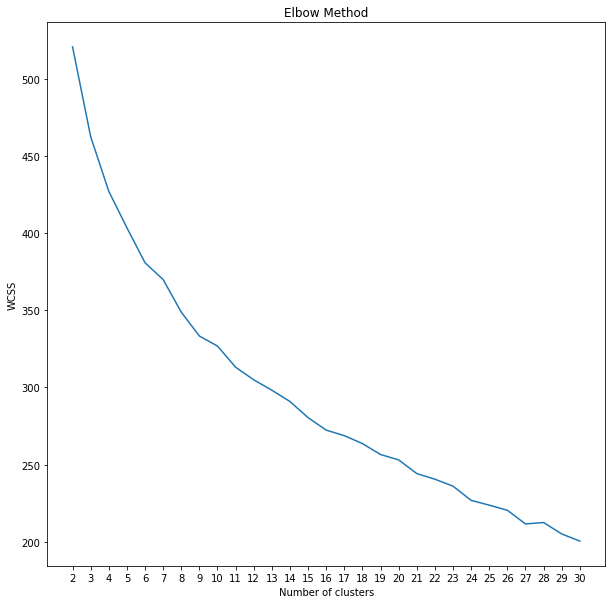

In [193]:
#trying to determine the optimal number of clusters with k-means for all the features with the elbow method
plt.rcParams['figure.figsize'] = [10, 10]
wcss = []
for i in range(2, 31):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=1000, n_init=10, random_state=0)
    kmeans.fit(clustering_normalized_np[:,:-1])
    wcss.append(kmeans.inertia_)
plt.plot(range(2, 31), wcss)
plt.xticks(np.arange(2, 31, 1.0))
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Due to "the curse of dimensionality", it is difficult to determine the optimal number of clusters for k-means with all the features

Therefore, we will try to find the features that are most indicative of the alcohol consumtion by using linear regression


## 5.2 Feature selection by weights from cluster and correlation

In [194]:
#running linear regression on features, with the target being alcohol consumption
X = clustering_normalized_np[:,:-1]
y = clustering_normalized_np[:,-1:]

mse = np.zeros(100)
warnings.filterwarnings('ignore')
for a in range(100):
    mse[a] = -np.mean(cross_val_score(Ridge(alpha=a/10.0), X=X, y=y, cv=5, scoring='neg_mean_squared_error'));

In [195]:
#getting weights for the best performing alpha value
best_alpha = np.argmin(mse)
ridge = Ridge(best_alpha/10.0)
ridge.fit(X, y);

In [196]:
#plotting weights
plt.rcParams['figure.figsize'] = [20, 5]
weights = pd.DataFrame({'_': ridge.coef_[0]}, index=clustering_normalized_df.columns.tolist()[:-1])
fig = go.Figure()
fig.add_trace(go.Bar( y = weights._, x=list(weights.index)))
fig.update_layout(title_text="Weights of features in regression model",
    yaxis_title="Weights",
    font=dict(
        family="Courier New, monospace",
        size=8,
        color="#7f7f7f"
    )
)

fig.show()

Alternatively, we can use correlations (as in hw2) to see which features are most indicative of the overall alcohol consumption

In [197]:
#calculating the correlations with alcohol consumption
correlations = clustering_normalized_df.corr().iloc[-1][:-1]
correlations = pd.DataFrame(correlations).T
correlations

,Age limits off-premise sales for beer,Age limits off-premise sales for wine,Age limits off-premise sales for spirits,Age limits on-premise service for beer,Age limits on-premise service for wine,Age limits on-premise service for spirits,Government support for earmarked funds,Government support for technical tools,Government support for training programmes,Government support for at-risk groups targeted,...,Restrictions on alcohol use in parks and streets,Restrictions on alcohol use in public transport,Restrictions on alcohol use in places of worship,Restrictions on alcohol use in sporting events,Restrictions on alcohol use in workplaces,HDI_2016,"Unemployment, total (% of labour force)",Median age (years),Gross domestic product (GDP) per capita (2011 PPP $),Education Index
Alcohol_per_capita,-0.197914,-0.196887,-0.170786,-0.176458,-0.176458,-0.150226,0.308649,0.246836,0.240992,0.15475,...,-0.113692,-0.280066,-0.381656,-0.245377,-0.308958,0.641083,0.063609,0.693265,0.522115,0.691215


In [198]:
#plotting correlation
correT = correlations.T
fig = go.Figure()
fig.add_trace(go.Bar( y = correT.Alcohol_per_capita, x=list(correT.index)))
fig.update_layout(title_text="Correlation of features to alcohol consumption",
    yaxis_title="correlation",
    font=dict(
        family="Courier New, monospace",
        size=8,
        color="#7f7f7f"
    )
)

fig.show()

In [199]:
#plotting correlation heatmap
corr = clustering_normalized_df.corr()

fig = go.Figure(data=go.Heatmap(
                   z=corr,
                   x=list(corr.index),
                   y=list(corr.columns),
                   hoverongaps = False))
fig.update_layout(title_text="Feature correlation heatmap",
    font=dict(
        family="Courier New, monospace",
        size=8,
        color="#7f7f7f"
    )
)


fig.show()


The heatmap shows clear groups of policies and restrictions that have higher correlations within the group, indicating that they are not independent, which is to be expected. If there is a restriction on alcohol use in parks and streets in a certain country, it is more likely that it also has a restriction on alcohol use in public transport, while if a licence is necessary for beer production, almost certainly there is one for wine production as well.

The problem is that even if these features have fairly high correlation with alcohol consumption (eg. GDP, Education index and HDI), the strong correlation among themselves mean that there is some redundancy in the information they provide us with. Partially for this reason, the previously generated weights for GDP, for example, are quite low, despite it having one of the highest correlations with the alcohol consumption.

It is also important to note, that the correlation values get as low as -0.45, which represents negative correlation, meaning that the feature in question has an inversed effect on the other feature. For instance, presence of the restriction on alcohol use in government offices seems to indicate a relatively low alcohol consumption in the said country, but also fairly low GDP. We do not know wheather there is a causality between these features, but it is an interesting pattern nonetheless.

In [200]:
#taking features that have |correlation| > 0.3 with alcohol consumption
#in this case, top 5 positively correlating and top 6 negatively correlating features
correlating_features = correlations.columns.tolist()[:5] + correlations.columns.tolist()[-6:]
clustering_normalized_np = clustering_normalized_df[correlating_features].to_numpy(copy=True)

## 5.3 Visualization of clustered countries by important features

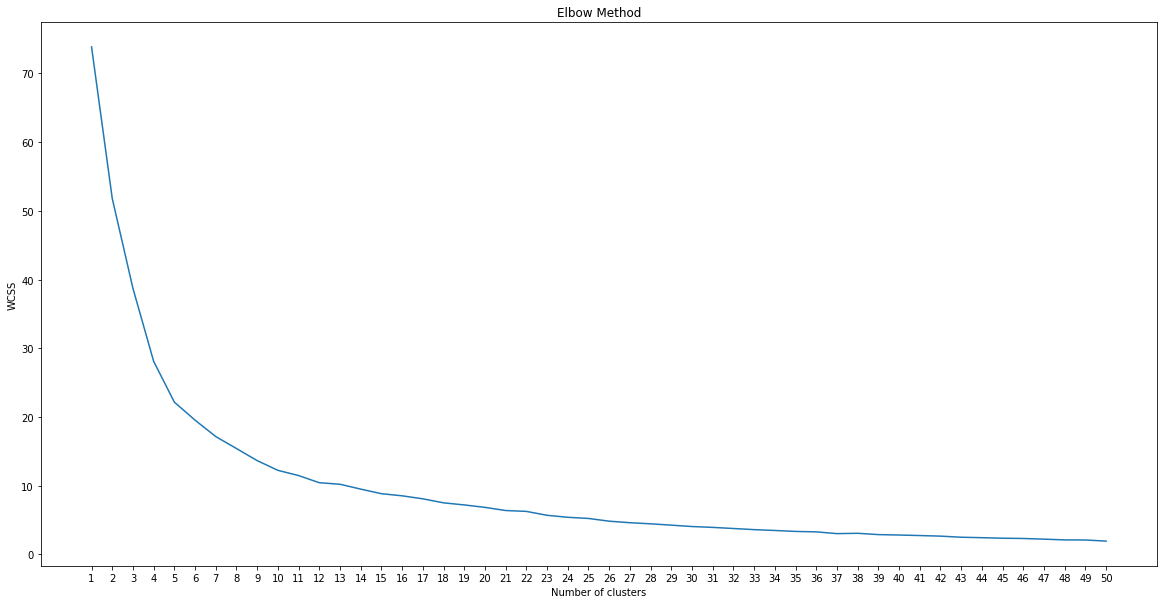

In [201]:
#trying to determine the optimal number of clusters with k-means for the correlating features
plt.rcParams['figure.figsize'] = [20, 10]
wcss = []
for i in range(1, 51):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=10000, n_init=10, random_state=0)
    kmeans.fit(clustering_normalized_np)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 51), wcss)
plt.xticks(np.arange(1, 51, 1.0))
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

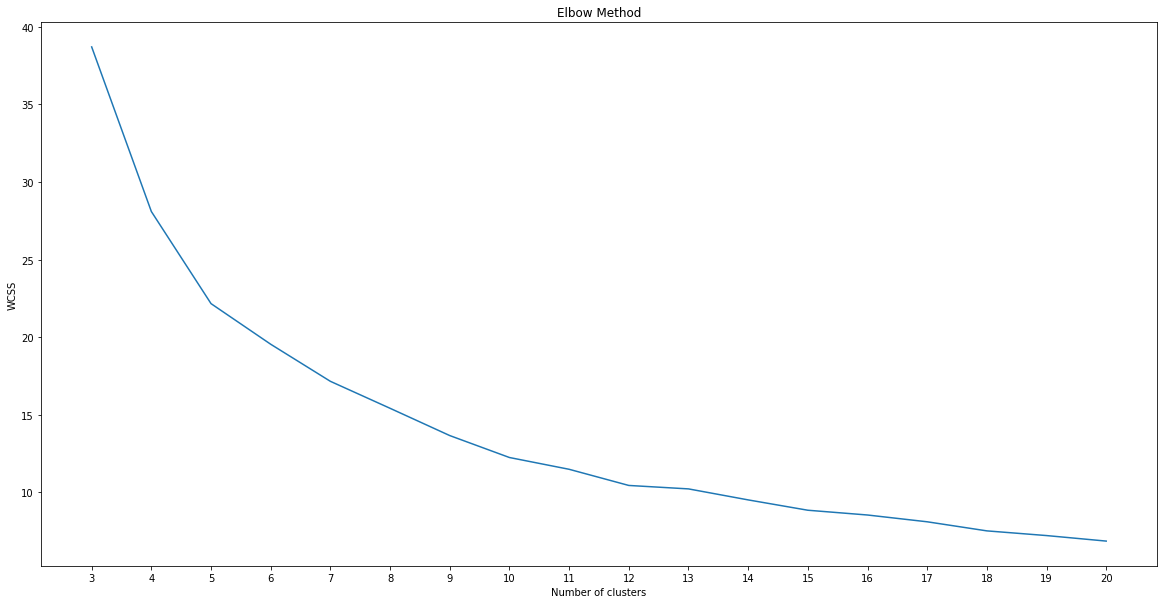

In [202]:
#trying to determine the optimal number of clusters with k-means for the correlating features (zoomed in)
plt.rcParams['figure.figsize'] = [20, 10]
plt.plot(range(3, 21), wcss[2:20])
plt.xticks(np.arange(3, 21, 1.0))
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

It appears that 12 clusters would be a reasonable choice

In [203]:
#clustering into 12 groups based on 11 selected features
kmeans = KMeans(n_clusters=12, init='k-means++', max_iter=10000, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(clustering_normalized_np)

In [204]:
#order clusters by average alcohol consumption
clustering_normalized_df["cluster"] = pred_y
ordered_clusters = clustering_normalized_df.groupby(['cluster']).mean().sort_values(by=['Alcohol_per_capita']).index.tolist()
clustering_normalized_df["cluster"] = clustering_normalized_df["cluster"].apply(lambda x : ordered_clusters[x])

In [205]:
#preparing df for visualization
clustering_df = clustering_normalized_df[["Alcohol_per_capita", "cluster"]]
clustering_df = clustering_df.join(df_all['Code'])
clustering_df = clustering_df[~clustering_df.index.duplicated(keep='first')]
clustering_df = clustering_df.rename(columns={'Code':'iso_a3'})
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world.merge(clustering_df, on='iso_a3')

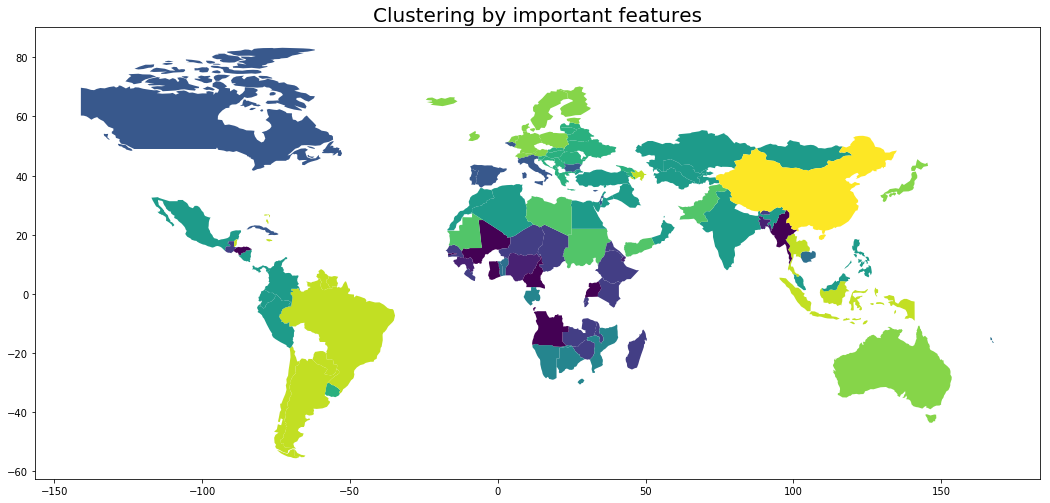

In [209]:
#visualizing clusters on the map
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 18, 18
fig, ax = plt.subplots(1, 1)
ax.set_title("Clustering by important features", fontsize=20)
world.plot(column='cluster', ax=ax);

# Plot those clusters on the map

fig = go.Figure(data=go.Choropleth(
    locations=world['iso_a3'].astype(str),
    z=world['cluster'].astype(float),
    colorscale='Blues',
    autocolorscale=False,
    reversescale=True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_tickprefix = 'Cluster NO.',
    colorbar_title = 'Cluster classes',
#     text=world['text'], # hover text
))

fig.update_layout(
    title_text='Clustering by important features',
    geo = dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
    
)

fig.show()